In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Use engine.execute to select and display the first 10 rows from the measurement table
result = engine.execute("select *  from measurement").fetchall()
#engine.execute('select * from measurement').fetchall()
print(result[:10])

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0), (2, 'USC00519397', '2010-01-02', 0.0, 63.0), (3, 'USC00519397', '2010-01-03', 0.0, 74.0), (4, 'USC00519397', '2010-01-04', 0.0, 76.0), (5, 'USC00519397', '2010-01-06', None, 73.0), (6, 'USC00519397', '2010-01-07', 0.06, 70.0), (7, 'USC00519397', '2010-01-08', 0.0, 64.0), (8, 'USC00519397', '2010-01-09', 0.0, 68.0), (9, 'USC00519397', '2010-01-10', 0.0, 73.0), (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]


In [9]:
# Use engine.execute to select and display the first 10 rows from the measurement table
result = engine.execute("select *  from station").fetchall()
#engine.execute('select * from measurement').fetchall()
print(result[:10])

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6), (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5), (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9), (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12_months = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())
#extract string from query object
last_12_months = list(np.ravel(last_12_months))[0]
#convert date string to datetime object
last_12_months = dt.datetime.strptime(last_12_months, '%Y-%m-%d')
#extract year, month, and day as integers
Year_extracted = int(dt.datetime.strftime(last_12_months, '%Y'))
Month_extracted = int(dt.datetime.strftime(last_12_months, '%m'))
Day_extracted = int(dt.datetime.strftime(last_12_months, '%d'))





In [14]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(Year_extracted, Month_extracted, Day_extracted) - dt.timedelta(days=365)
year_ago 

datetime.date(2016, 8, 23)

In [15]:
# Perform a query to retrieve the data and precipitation scores
prcp_Data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > year_ago)
                  .order_by(Measurement.date)
                  .all())
#prcp_Data 

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
query_df = pd.DataFrame(prcp_Data)
#set index
query_df = query_df.set_index('date')


In [16]:
# Sort the dataframe by date
query_df = query_df.sort_index(ascending=True)

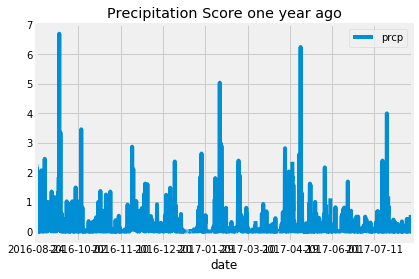

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
query_df.plot(title="Precipitation Score one year ago")

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
query_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
station_available = session.query(Station).count()
print(f"station_available: {station_available}")


station_available: 9


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
active_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
#most active station
stationID = active_station[0][0]
stationID

'USC00519281'

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#1 lowest temp for most active station
lowest_Temp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowest_Temp = lowest_Temp[0]
print(f"lowest temperature recorded at {stationID} is {lowest_Temp} degrees Farenheit.")

lowest temperature recorded at USC00519281 is 54.0 degrees Farenheit.


In [24]:
# 2 hishest temp for most active station
highest_Temp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.desc())
                     .first())
highest_Temp = highest_Temp[0]
print(f"highest temperature recorded at {stationID} is {highest_Temp} degrees Farenheit.")

highest temperature recorded at USC00519281 is 85.0 degrees Farenheit.


In [25]:
# average temp for most active station
avgTemp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"The average temperature recorded {stationID} is {avgTemp} degrees Farenheit.")

The average temperature recorded USC00519281 is 71.7 degrees Farenheit.


In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_temp_observed = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

highest = high_temp_observed[0][0]    
for station, count in high_temp_observed:
    print("Station",station,"had",count, "weather observations.")

Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


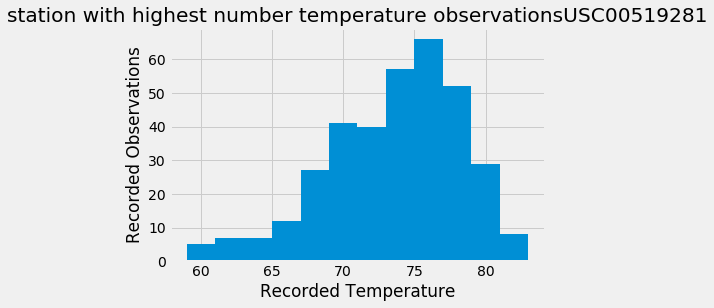

In [30]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == highest).\
    filter(Measurement.date > year_ago ).\
    order_by(Measurement.date).all()
temp2_df=pd.DataFrame(high_temperature)
plt.hist(temp2_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Recorded Observations")
plt.title("station with highest number temperature observations" + highest)
plt.show()

## Bonus Challenge Assignment

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2016-12-28','2017-01-01')
trip_temps

[(62.0, 70.3125, 77.0)]

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps_df=pd.DataFrame(trip_temps, columns=["tmin","tavg","tmax"])
trip_temps_df

NameError: name 'trip_temps' is not defined

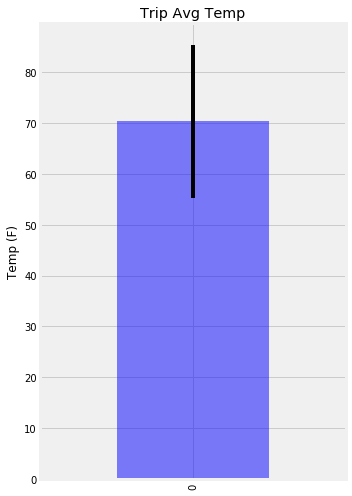

In [30]:
trip_temps_df.plot.bar(y='tavg', yerr=(trip_temps_df['tmax'] - trip_temps_df['tmin']), title='Trip Avg Temp', color='blue', alpha=0.5, figsize=(5,7))
plt.xticks = np.arange(len(trip_temps_df))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_rainfall = \
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
filter(Measurement.station == Station.station).\
filter(Measurement.date >= '2016-12-28').\
filter(Measurement.date <= '2017-01-01').\
group_by(Measurement.station).\
order_by(Measurement.prcp.desc()).all()

print(trip_rainfall)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.14), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.09), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.09), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.06), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.01), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


In [36]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [37]:
# calculate the daily normals for your trip
trip_dates = ["12-28", "12-29", "12-30", "12-31", "01-01"]

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []

for trip_date in trip_dates:
    day = {}
    day['Date'] = f"2016-{trip_date}"
    normal = daily_normals(trip_date)
    day['Min'] = normal[0][0]
    day['Avg'] = normal[0][1]
    day['Max'] = normal[0][2]
    normals.append(day)
    
normals

[{'Date': '2016-12-28', 'Min': 62.0, 'Avg': 70.52083333333333, 'Max': 77.0},
 {'Date': '2016-12-29', 'Min': 57.0, 'Avg': 70.29166666666667, 'Max': 78.0},
 {'Date': '2016-12-30', 'Min': 63.0, 'Avg': 69.86363636363636, 'Max': 76.0},
 {'Date': '2016-12-31', 'Min': 56.0, 'Avg': 68.27906976744185, 'Max': 77.0},
 {'Date': '2016-01-01', 'Min': 62.0, 'Avg': 69.15384615384616, 'Max': 77.0}]

In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
#load into a data frame
normals_df = pd.DataFrame(normals)
normals_df.set_index('Date', inplace = True)
normals_df

,Min,Avg,Max
Date,,,
2016-12-28,62.0,70.520833,77.0
2016-12-29,57.0,70.291667,78.0
2016-12-30,63.0,69.863636,76.0
2016-12-31,56.0,68.279070,77.0
2016-01-01,62.0,69.153846,77.0


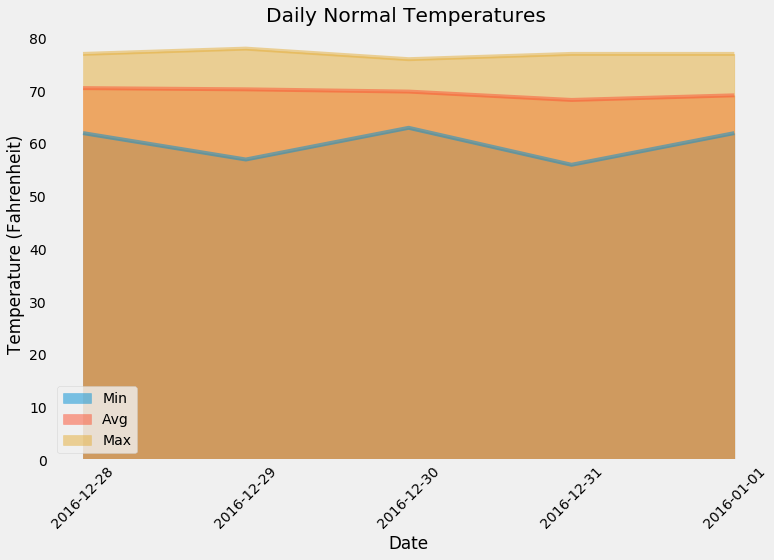

In [39]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize = (11, 8))
normals_df.plot.area(ax = ax, stacked = False)

#set labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures ')

#set ticks
dates = [f"2016-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45)

#save figure
plt.savefig('Images/dailynormals.png')

#show
plt.grid()
plt.tight_layout()
plt.show()